In [7]:
import boto3
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report


### defining bucket###
s3=boto3.resource('s3')
bucket_name= 'dmw-448'
bucket = s3.Bucket(bucket_name)

### definging CSV ###
file_key = 'train.csv'
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')


# Reading the csv file and seperating columkns
train = pd.read_csv(file_content_stream, sep = '|')
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [8]:
# Defining the file to be read from s3 bucket
file_key = "test.csv"

bucket_object1 = bucket.Object(file_key)
file_object1 = bucket_object1.get()
file_content_stream = file_object1.get('Body')

# Reading the csv file
test = pd.read_csv(file_content_stream, sep = '|')
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [10]:
#creating variables 
train['interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012), 1, 0)
train['interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] > 0.012) & (train['totalScanTimeInSeconds'] <= 895.0), 1, 0)
train['interaction_3'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] > 0.012) & (train['totalScanTimeInSeconds'] > 895.0), 1, 0)
train['interaction_4'] = np.where((train['trustLevel'] > 1.5) & (train['trustLevel'] <= 2.5) & (train['totalScanTimeInSeconds'] <= 1298.0), 1, 0)
train['interaction_5'] = np.where((train['trustLevel'] > 1.5) & (train['trustLevel'] <= 2.5) & (train['totalScanTimeInSeconds'] > 1298.0), 1, 0)
train['interaction_6'] = np.where((train['trustLevel'] > 1.5) & (train['trustLevel'] > 2.5), 1, 0)


test['interaction_1'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012), 1, 0)
test['interaction_2'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] > 0.012) & (test['totalScanTimeInSeconds'] <= 895.0), 1, 0)
test['interaction_3'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] > 0.012) & (test['totalScanTimeInSeconds'] > 895.0), 1, 0)
test['interaction_4'] = np.where((test['trustLevel'] > 1.5) & (test['trustLevel'] <= 2.5) & (test['totalScanTimeInSeconds'] <= 1298.0), 1, 0)
test['interaction_5'] = np.where((test['trustLevel'] > 1.5) & (test['trustLevel'] <= 2.5) & (test['totalScanTimeInSeconds'] > 1298.0), 1, 0)
test['interaction_6'] = np.where((test['trustLevel'] > 1.5) & (test['trustLevel'] > 2.5), 1, 0)

In [11]:
## Engineering three features by using the strong heredity principle
train['feature_1'] = train['interaction_3'] * train['trustLevel']
train['feature_2'] = train['interaction_3'] * train['interaction_6']
train['feature_3'] = train['interaction_6'] * train['trustLevel']

In [12]:
test['feature_1'] = test['interaction_3'] * test['trustLevel']
test['feature_2'] = test['interaction_3'] * test['interaction_6']
test['feature_3'] = test['interaction_6'] * test['trustLevel']

In [14]:
#Defining variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

#creating lists for each models results
LR_results = list()
RF_results = list()
ADA_results = list()

#creating loop for model
for i in tqdm(range(0, 100)):
    
    #splitting data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    #creating logistic regression model wiht RFE
    LR = RFE(estimator = LogisticRegression(max_iter = 10000), n_features_to_select = 5).fit(X_train, Y_train)
    #Appeding results
    LR_results.append(LR.support_)
    
    #creating random forrest model wiht RFE
    RF = RFE(estimator = RandomForestClassifier(max_depth = 3, n_estimators = 500), n_features_to_select = 5).fit(X_train, Y_train)
    #Appending results
    RF_results.append(RF.support_)
    
    #creating adaboost model wiht RFE
    ADA = RFE(estimator = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = 0.01), n_features_to_select = 5).fit(X_train, Y_train)
    #appending results
    ADA_results.append(ADA.support_)

100%|██████████| 100/100 [1:20:39<00:00, 48.40s/it]


In [16]:
#Converting to data frames
#Logistic Regression
LR = pd.DataFrame(LR_results, columns = X.columns)
LR_1 = 100 * LR.apply(np.sum, axis = 0) / LR.shape[0]

#Random Forest
RF = pd.DataFrame(RF_results, columns = X.columns)
RF_1 = 100 * RF.apply(np.sum, axis = 0) / RF.shape[0]

#Ada boost
ADA = pd.DataFrame(ADA_results, columns = X.columns)
ADA_1 = 100 * ADA.apply(np.sum, axis = 0) / ADA.shape[0]



Text(0.5, 1.0, 'AdaBoost Classifier')

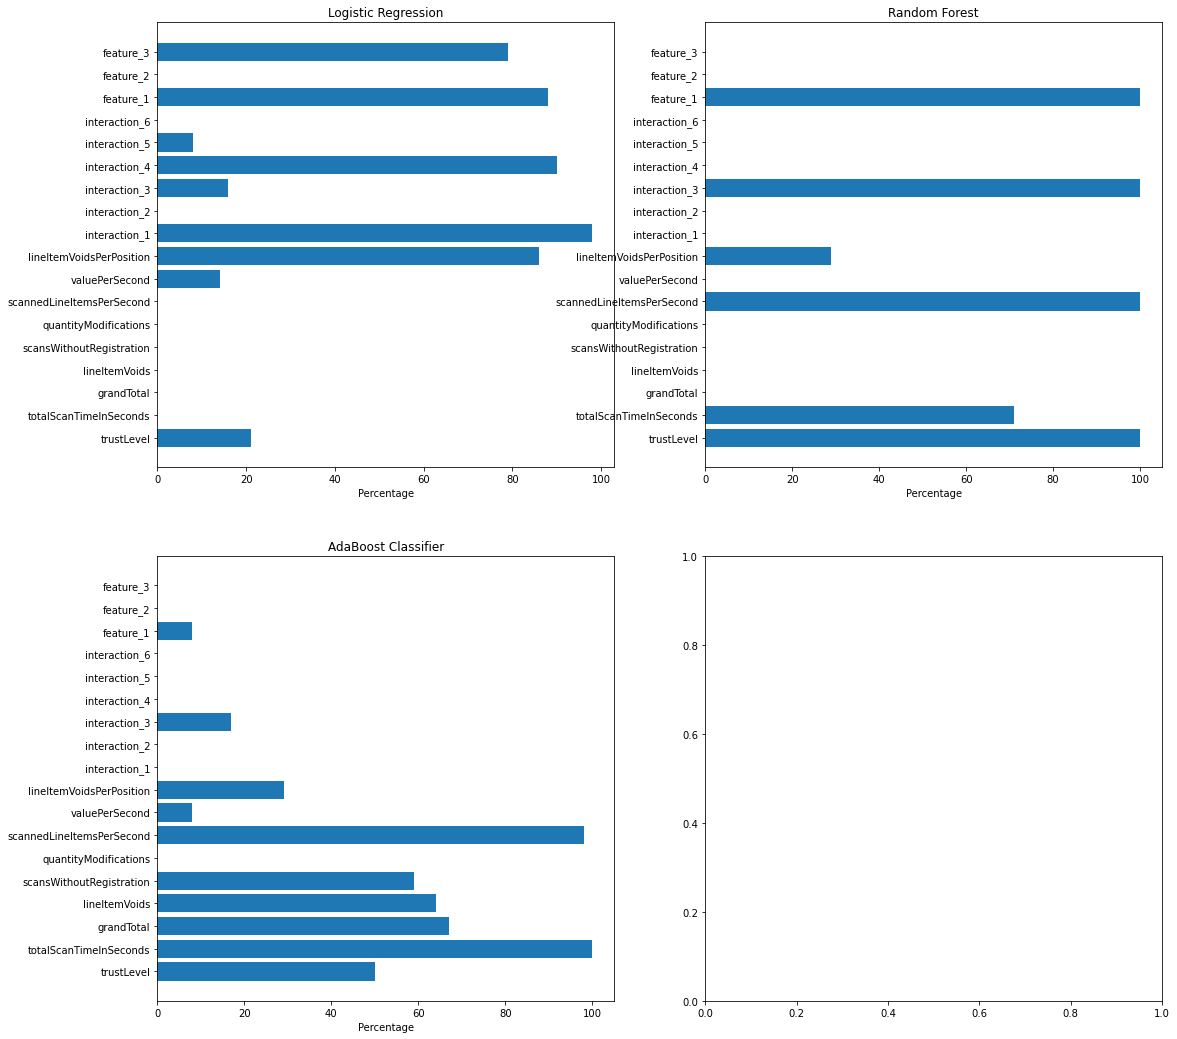

In [19]:
#Graphing results after 2 hours of figuring out how to do these stupid graphs 
fig, axes = plt.subplots(2, 2, figsize = (18, 18))
#Logistic Regression
axes[0, 0].barh(LR_1.index, LR_1.values)
axes[0, 0].set_xlabel('Percentage')
axes[0, 0].set_title('Logistic Regression')
#Random Forrest
axes[0, 1].barh(RF_1.index, RF_1.values)
axes[0, 1].set_xlabel('Percentage')
axes[0, 1].set_title('Random Forest')
#Ada Boost
axes[1, 0].barh(ADA_1.index, ADA_1.values)
axes[1, 0].set_xlabel('Percentage')
axes[1, 0].set_title('AdaBoost Classifier')